In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime 
from datetime import timedelta
import os
from constants import *
from trip_file import TripFile
from trip import Trip
from tqdm import tqdm
import seaborn as sns


In [3]:
taarif = pd.read_csv("../files/taarif.csv")
taarif = taarif.drop(0).reset_index().drop(columns=["index"]) # first row is nulls
new_drivers = pd.read_csv("../files/new_drivers.csv", index_col=0)
drivers_with_kviut = pd.read_csv("../files/drivers_with_kviut.csv",index_col=0)

In [4]:
def preprocess_drivers(drivers: pd.DataFrame, copy=False) -> pd.DataFrame:
    df = drivers
    if copy:
        df = drivers.copy()

    gender_mapping = {"F": FEMALE,
                    "M":MALE,
                    "m":MALE,
                    "male":MALE,
                    "boy":MALE,
                    "unknown":UNKOWN,
                    'woman':FEMALE,
                    'girl':FEMALE,
                    'none':UNKOWN,
                    'female':FEMALE,
                    UNKOWN:UNKOWN}

    # Make preprocess
    df.gender = df.gender.fillna(UNKOWN)
    df.gender = df.gender.apply(lambda x: gender_mapping[x])
    df.birthdate = pd.to_datetime(df.birthdate, format="mixed")
    drivers.birthdate = drivers.birthdate.fillna(datetime.datetime.now())

    return df

def preprocess_taarif(taarif_df: pd.DataFrame, copy=False) -> pd.DataFrame:
    df = taarif_df
    if copy:
        df = new_drivers.copy()

    customers_mapping = {
            "dbs" : "yes",
            "mizranei_kfar_saba": "aminach",
            "telecommunication_ltd": "hot" 
    }

    for customer, new_customer in customers_mapping.items():
        # Select the row to duplicate (let's say the first row, index 0)
        row_to_duplicate = df[df["customer"] == customer]
        # Make a copy of the row
        new_row = row_to_duplicate.copy()
        new_row["customer"] = new_customer
        # Append the modified row to the DataFrame
        df = pd.concat([df,pd.DataFrame(new_row)], ignore_index=True)
        
    return df


# Concat the two tables of drivers with and without kviut
def concat_drivers_tables(new_drivers, drivers_with_kviut):
    drivers_with_kviut["kviut"] = 1
    drivers = pd.concat([new_drivers, drivers_with_kviut])
    drivers["kviut"] = drivers["kviut"].fillna(0)
    return drivers
    

In [5]:
drivers = concat_drivers_tables(new_drivers, drivers_with_kviut)
drivers = preprocess_drivers(drivers, copy=True)
taarif = preprocess_taarif(taarif)

In [6]:
def get_trip_files(folder, limit=100):
    files = np.array(list(os.listdir(folder)))
    if limit:
        files = files[:limit]
    files = np.array([name if not name[-5] == ")" else name[:-7]+".csv" for name in files])
    print("Processing files....")
    return np.array([TripFile(os.path.join(folder,file)) for file in tqdm(files)])


In [7]:
trip_files = get_trip_files("../files/trips_data", limit=None)

Processing files....


 16%|█▋        | 996/6111 [00:16<01:12, 70.12it/s] c:\Users\Ron Tohar\Desktop\הכשרה\CV_training\basic\python\Basic - Azrieli & Sons data\project_files\trip_file.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  trips_df.end_time = pd.to_datetime(trips_df.end_time)
100%|██████████| 6111/6111 [01:35<00:00, 63.79it/s]


In [124]:
all_dfs = [trip_file.get_data_frame() for trip_file in trip_files ]
trips_df = pd.concat(all_dfs)
trips_df.end_time = pd.to_datetime(trips_df["end_time"])
trips_df.start_time = pd.to_datetime(trips_df["start_time"])
trips_df["kph"] = trips_df["km"] / ((trips_df["end_time"] - trips_df["start_time"]) / datetime.timedelta(hours=1))

trips_df = trips_df.reset_index().drop(columns=["index"])
trips_df["drive_time"] = (trips_df["end_time"]-trips_df["start_time"]) / timedelta(hours=1)

# trips_df




In [125]:

# Function to transform values in second DataFrame to match the distribution of the first DataFrame
def transform_distribution(df1, df2):
    # Calculate CDF of first DataFrame
    cdf_values = np.cumsum(df1['kph']) / np.sum(df1['kph'])
    
    # Generate random numbers based on CDF
    random_values = np.random.rand(len(df2))
    
    # Map random values to quantiles of CDF
    transformed_values = np.interp(random_values, cdf_values, df1['kph'])
    
    # Replace values in second DataFrame
    df2['kph'] = transformed_values
    
    return df2

kph1 = pd.DataFrame(trips_df[(trips_df["kph"] <100) & (trips_df["kph"] >50)])
kph2 = pd.DataFrame(trips_df[(trips_df["kph"] <50)])
kph3 = transform_distribution(kph1,trips_df.copy())
trips_df["kph_fixed"] = kph3["kph"]


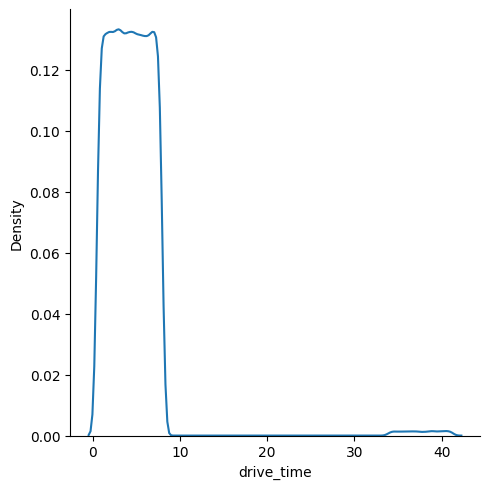

In [126]:
sns.displot(x="drive_time", data=trips_df, kind="kde")


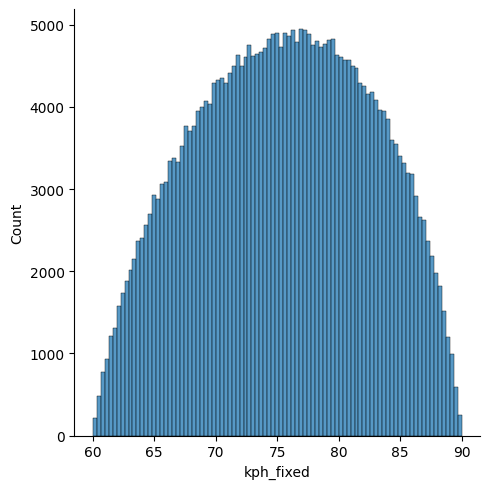

In [127]:
sns.displot(x="kph_fixed", data=trips_df)


### Observe trips hours


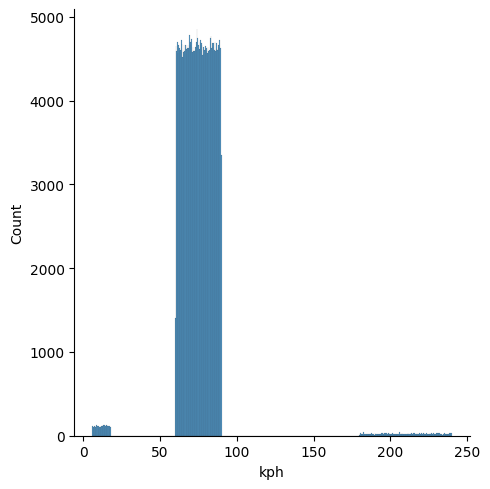

In [47]:
sns.displot(x="kph", data=trips_df)

#### What are the trips that take more then 10 hours?

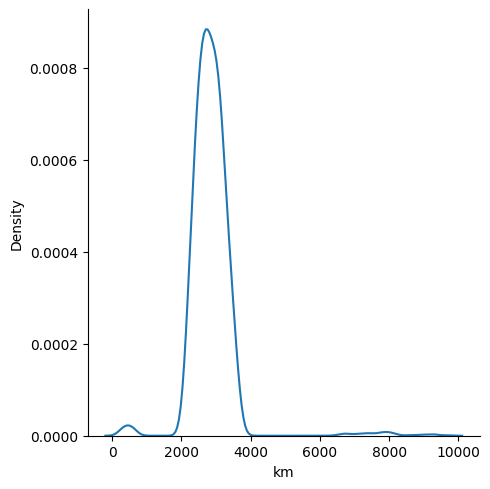

In [39]:
long_drives = trips_df[trips_df["drive_time"] >15]
sns.displot(x="km", data=long_drives, kind="kde")
# sns.displot(x="km", data=trips_df, kind="kde")

<Axes: xlabel='drive_time', ylabel='kph'>

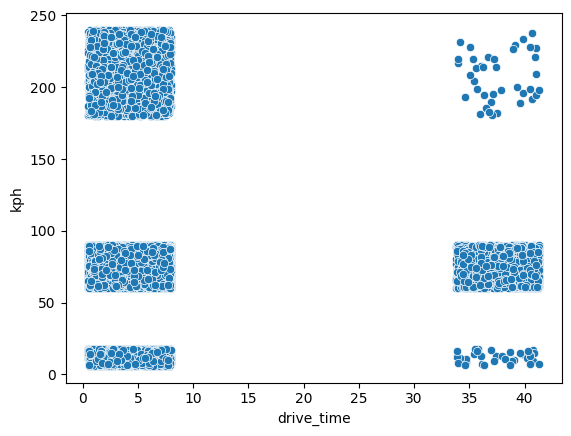

In [140]:
sns.scatterplot(x="drive_time", y="kph", data=trips_df)
# sns.displot(x="drive_time", y="km", data=trips_df[trips_df["drive_time"]<15])

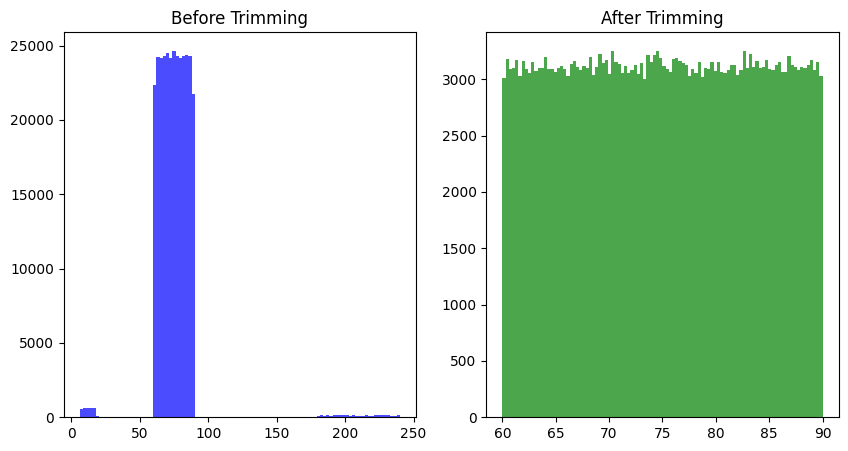

In [139]:
import pandas as pd
import numpy as np

# Create a sample dataframe (replace this with your actual dataframe)

df = trips_df[~trips_df["kph"].isna()]

# Calculate z-scores
z_scores = (df['kph'] - df['kph'].mean()) / df['kph'].std()

# Define a threshold for outliers (e.g., |z-score| > 3)
threshold = 3

# Identify outliers
outliers = df[abs(z_scores) > threshold]

# Trim outliers
trimmed_df = df[abs(z_scores) <= threshold]

# Visualize the distribution before and after trimming
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(df['kph'], bins=100, color='blue', alpha=0.7)
plt.title('Before Trimming')

plt.subplot(1, 2, 2)
plt.hist(trimmed_df['kph'], bins=100, color='green', alpha=0.7)
plt.title('After Trimming')

plt.show()


In [144]:
trips_df[(trips_df["start_time"].isna()) & (trips_df["end_time"].isna())]

,customer,driver_id,end_time,km,start_time,kph,drive_time,kph_fixed
12833,yes,653,NaT,454.815943,NaT,NaN,NaN,66.808507
22709,yes,643,NaT,57.974586,NaT,NaN,NaN,66.642758
24041,osem,705,NaT,197.556857,NaT,NaN,NaN,86.049727
24580,intel,52,NaT,99.175149,NaT,NaN,NaN,75.320953
32551,tnuva,295,NaT,168.653256,NaT,NaN,NaN,80.129157
46365,tnuva,414,NaT,630.036986,NaT,NaN,NaN,69.956750
48658,jerusalem_muni,201,NaT,122.775826,NaT,NaN,NaN,84.940580
57045,bituch_leumi,136,NaT,285.179849,NaT,NaN,NaN,60.981146
82566,iaf,775,NaT,196.836166,NaT,NaN,NaN,70.475195
91805,hot,620,NaT,91.182702,NaT,NaN,NaN,87.723359


### Learning kph and start time relationg

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

trips_with_start = trips_df[~trips_df["start_time"].isna()]
trips_with_start["day_of_week"] = trips_with_start["start_time"].dt.day_of_week
trips_with_start["hour"] = trips_with_start["start_time"].dt.hour
trips_with_start["minute"] = trips_with_start["start_time"].dt.minute



# Load your dataset and preprocess it

# Split features and target variable
X = trips_with_start[['day_of_week', 'hour', "minute", 'km']].values
y = trips_with_start['kph_fixed'].values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define LSTM model
model = Sequential([
    Dense(16, input_shape=(X_train.shape[1], 1)),
    Dense(1)
])

# Compile model
model.compile(optimizer='adam', loss='mse')

# Reshape input data for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Train model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Make predictions for rows with missing end times
# Preprocess the data for prediction and use model.predict() to get predicted end times

In [123]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Load your dataset and preprocess it
df1 = trips_with_start.copy()
df1["drive_time"] = (df1["end_time"]-df1["start_time"]) / timedelta(hours=1)
df1 = df1[df1["drive_time"] < 15]
df1["day_of_week"] = df1["day_of_week"].astype("category")
df1["is_weekend"] = df1["day_of_week"].apply(lambda x: x==5 or x==6)


# Split features and target variable
# X = df1[['day_of_week', 'hour', "minute", 'km']].values
X = df1[['day_of_week', 'hour', "minute","is_weekend"]].values
y = df1['kph_fixed'].values


# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define and train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 49.72375369076764


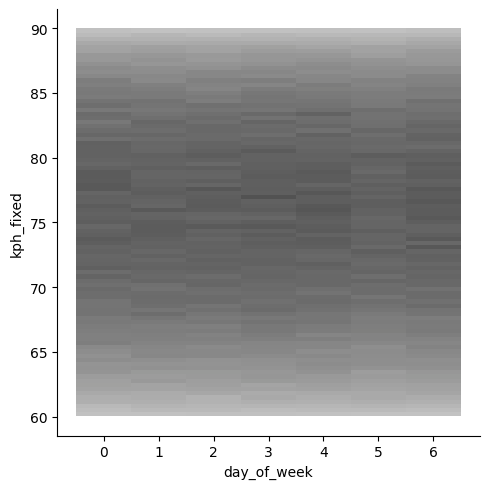

In [117]:
# print(y_train.mean(), y_train)
# mean_squared_error(np.full(len(y_test), y_test.mean()), y_test)
# print(len(trips_with_start))
# print(model.coef_)
import matplotlib
color = matplotlib.colors.BASE_COLORS
# p = sns.color_palette("rocket", as_cmap=True)
sns.displot(y="kph_fixed", x="day_of_week", data=trips_with_start, color=color["w"])
# sns.color_palette("icefire", as_cmap=True)

In [116]:
matplotlib.colors.BASE_COLORS

{'b': (0, 0, 1),
 'g': (0, 0.5, 0),
 'r': (1, 0, 0),
 'c': (0, 0.75, 0.75),
 'm': (0.75, 0, 0.75),
 'y': (0.75, 0.75, 0),
 'k': (0, 0, 0),
 'w': (1, 1, 1)}